In order to run a logistic regression, there are a few assumptions that must be satisfied. Those being:

(a) The dependant variable is binary (or ordinal with two options).

(b) The data is free of missing values.

(c) All predictors (or observations) are independant of each other.

(d) The independant variables have little to no multicollinearity.

(e) Large enough sample size. A general guideline being at least 10 cases with the least frequent outcome for each independant variable. In other words, if you have 5 independant variables and the expected probability of our least frequent outcome is 0.10, then you would need a minimum sample size of 500 (10*5/0.10).

We can easily check this as follows.

### Collecting Data

First, we must download the appropriate libraries and take a look at our dataset. It is important to note that for the 'HomeAdv' column a 1 correpsonds to 'yes' and a 0 corresponds to 'no'. For the 'Outcome' column, a 1 correpsponds to a 'win' and a 0 corresponds to a 'loss'.

In [49]:
import pandas as pd #for data analysis
import numpy as np #for scientific computations
import seaborn as sns #for statistical plotting
import matplotlib.pyplot as plt #for plotting
%matplotlib inline
import math #for mathematical computations
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [50]:
nhl_data = pd.read_csv('~/Desktop/capstone_project/flamesMatchup_15-19v2.csv', delimiter = ',')
nhl_data.head(10)

,GP,Date,HomeAdv,Opponent,GF,GA,Outcome,S,PIM,PPG,...,CA,CF%,FF,FA,FF%,FOW,FOL,FO%,oZS%,PDO
0,1,2015-10-07,1,Vancouver Canucks,1,5,0,30,38,0,...,51,49.5,39,43,47.6,29,28,50.9,63.0,89.3
1,2,2015-10-10,0,Vancouver Canucks,3,2,1,38,12,1,...,44,56.9,39,35,52.7,28,30,48.3,57.4,102.1
2,3,2015-10-13,1,St. Louis Blues,3,4,0,18,2,1,...,55,41.5,25,36,41.0,17,30,36.2,40.0,101.8
3,4,2015-10-16,0,Winnipeg Jets,1,3,0,20,8,0,...,47,42.0,25,33,43.1,23,27,46.0,31.4,94.4
4,5,2015-10-17,1,Edmonton Oilers,2,5,0,24,13,1,...,45,45.1,24,30,44.4,28,34,45.2,55.6,88.1
5,6,2015-10-20,1,Washington Capitals,2,6,0,19,6,0,...,52,40.9,25,40,38.5,26,30,46.4,45.4,89.5
6,7,2015-10-23,1,Detroit Red Wings,3,2,1,40,15,0,...,49,54.2,47,30,61.0,26,26,50.0,51.2,108.3
7,8,2015-10-25,0,New York Rangers,1,4,0,23,6,0,...,48,48.4,29,32,47.5,21,20,51.2,38.4,89.6
8,9,2015-10-26,0,New York Islanders,0,4,0,29,16,0,...,55,46.6,38,41,48.1,22,25,46.8,51.5,90.0
9,10,2015-10-28,0,Ottawa Senators,4,5,0,38,8,1,...,42,57.1,43,26,62.3,21,34,38.2,57.3,87.8


Now we will put the file into a data frame and create two new features from the existing columns. These will be Power Play Percentage (PP%) and Penalty Kill Percentage (PK%), which simply correlate the information from two columns into one for ease of calculation. For example, 1 power play goal (PPG) on 2 power play oppurtunities (PPO) will result in a 50% PP% or in our case, simply 0.5, again for ease of calculation.

In [52]:
df = pd.DataFrame(nhl_data)
df['PP%'] = df['PPG'] / df['PPO']
df['PK%'] = (df['PPOA'] - df['PPGA']) / df['PPOA']
df.head(5)

,GP,Date,HomeAdv,Opponent,GF,GA,Outcome,S,PIM,PPG,...,FF,FA,FF%,FOW,FOL,FO%,oZS%,PDO,PP%,PK%
0,1,2015-10-07,1,Vancouver Canucks,1,5,0,30,38,0,...,39,43,47.6,29,28,50.9,63.0,89.3,0.00,1.00
1,2,2015-10-10,0,Vancouver Canucks,3,2,1,38,12,1,...,39,35,52.7,28,30,48.3,57.4,102.1,0.50,0.75
2,3,2015-10-13,1,St. Louis Blues,3,4,0,18,2,1,...,25,36,41.0,17,30,36.2,40.0,101.8,0.25,0.00
3,4,2015-10-16,0,Winnipeg Jets,1,3,0,20,8,0,...,25,33,43.1,23,27,46.0,31.4,94.4,0.00,1.00
4,5,2015-10-17,1,Edmonton Oilers,2,5,0,24,13,1,...,24,30,44.4,28,34,45.2,55.6,88.1,0.25,0.75


We can check (a) very easily by confirming our dependant variable has two outcomes:

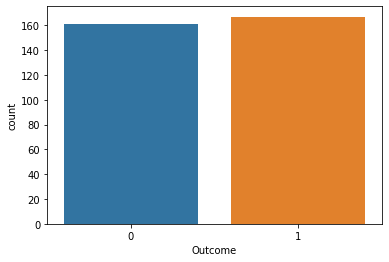

In [8]:
sns.countplot(x='Outcome', data = df)

This clearly shows we have only two possible values for the predictant variable "Outcome", with a near equal distribution. Now, we can go ahead and check (b):

In [53]:
df.isnull().sum()

GP          0
Date        0
HomeAdv     0
Opponent    0
GF          0
GA          0
Outcome     0
S           0
PIM         0
PPG         0
PPO         0
SHG         0
SA          0
PIMA        0
PPGA        0
PPOA        0
SHGA        0
CF          0
CA          0
CF%         0
FF          0
FA          0
FF%         0
FOW         0
FOL         0
FO%         0
oZS%        0
PDO         0
PP%         6
PK%         3
dtype: int64

It appears our formula's for PP% and PK% give us a division error when PPO and PPOA are zero. Therefore, we will replace these null values with the mean of each feature:

In [54]:
df.mean(skipna = True)

GP         41.500000
HomeAdv     0.500000
GF          2.939024
GA          2.914634
Outcome     0.509146
S          31.100610
PIM        10.112805
PPG         0.591463
PPO         3.268293
SHG         0.131098
SA         29.228659
PIMA       10.310976
PPGA        0.631098
PPOA        3.128049
SHGA        0.079268
CF         48.536585
CA         45.634146
CF%        51.576829
FF         35.737805
FA         33.881098
FF%        51.270732
FOW        24.350610
FOL        24.234756
FO%        50.111585
oZS%       50.468902
PDO        99.508841
PP%         0.180450
PK%         0.795696
dtype: float64

In [55]:
df['PP%'].fillna('0.180450', inplace = True)
df['PK%'].fillna('0.795696', inplace = True)

and now, checking again:

In [59]:
df.isnull().sum()

GP          0
Date        0
HomeAdv     0
Opponent    0
GF          0
GA          0
Outcome     0
S           0
PIM         0
PPG         0
PPO         0
SHG         0
SA          0
PIMA        0
PPGA        0
PPOA        0
SHGA        0
CF          0
CA          0
CF%         0
FF          0
FA          0
FF%         0
FOW         0
FOL         0
FO%         0
oZS%        0
PDO         0
PP%         0
PK%         0
dtype: int64

we have confirmed that there are now no missing data values in the data frame. In the next section we will confirm (c) through (e).

### Analyzing Data

Firstly, we must choose our predictors, to do so we will individually calculate the pearson correlation for 'Outcome' and relevant features to see which features have the greatest affect on the outcome of a hockey game. Of course, there are some dependent variables which we wont test as it is immediately obvious they have no effect on the outcome of the game. I feel confident in making this judgement based on my experience, being a fan of the game for close to 20 years, and playing it for 10 of those. With that being said, we run the pearson and spearman on the following:

In [60]:
pearson = df.corr(method = 'pearson')
pearson

,GP,HomeAdv,GF,GA,Outcome,S,PIM,PPG,PPO,SHG,...,CA,CF%,FF,FA,FF%,FOW,FOL,FO%,oZS%,PDO
GP,1.000000,0.005410,0.015782,-0.057054,-0.008374,0.052176,0.040236,-0.038368,-0.073249,0.014530,...,-0.058227,0.072160,0.076352,-0.058124,0.077964,-0.056359,-0.040461,-0.013245,-0.018067,-0.027938
HomeAdv,0.005410,1.000000,0.178363,0.056861,0.054887,0.116173,-0.092399,0.039314,-0.031996,0.007559,...,-0.103279,0.182816,0.170881,-0.093280,0.170759,0.253566,0.069245,0.137692,0.150828,0.039217
GF,0.015782,0.178363,1.000000,-0.029134,0.650236,0.151530,-0.002200,0.455289,0.065522,0.244555,...,0.010024,-0.044238,0.033421,-0.008324,0.035937,0.203330,0.049415,0.121121,-0.180834,0.564704
GA,-0.057054,0.056861,-0.029134,1.000000,-0.589118,0.115468,0.174999,0.063151,0.099664,0.082251,...,-0.115660,0.195258,0.151759,-0.041397,0.131624,0.111370,0.114256,-0.015809,0.280737,-0.622339
Outcome,-0.008374,0.054887,0.650236,-0.589118,1.000000,0.018210,-0.077820,0.229834,-0.023220,0.062093,...,0.124773,-0.169782,-0.047468,0.060420,-0.064893,0.077480,-0.003859,0.064283,-0.326982,0.738705
S,0.052176,0.116173,0.151530,0.115468,0.018210,1.000000,-0.065951,0.090789,0.166752,0.093664,...,-0.220030,0.555794,0.709192,-0.192088,0.634558,0.135938,0.101446,0.014656,0.377895,-0.217923
PIM,0.040236,-0.092399,-0.002200,0.174999,-0.077820,-0.065951,1.000000,0.044078,0.112467,0.107776,...,-0.147645,0.029466,-0.120812,-0.082381,-0.036676,-0.136928,-0.025481,-0.077661,0.030977,-0.053010
PPG,-0.038368,0.039314,0.455289,0.063151,0.229834,0.090789,0.044078,1.000000,0.368624,0.112743,...,-0.116541,-0.031062,-0.138277,-0.112764,-0.018863,0.000738,0.057813,-0.046350,-0.019381,0.001772
PPO,-0.073249,-0.031996,0.065522,0.099664,-0.023220,0.166752,0.112467,0.368624,1.000000,0.091539,...,-0.314302,0.047538,-0.285194,-0.311504,0.017357,-0.176585,-0.213928,0.027775,0.054186,-0.124230
SHG,0.014530,0.007559,0.244555,0.082251,0.062093,0.093664,0.107776,0.112743,0.091539,1.000000,...,-0.050952,-0.004184,-0.055534,-0.012218,-0.026620,0.033129,-0.113596,0.130301,-0.056038,-0.081824


In [16]:
spearman = df.corr(method = 'spearman')
spearman

,GP,HomeAdv,GF,GA,Outcome,S,PIM,PPG,PPO,SHG,...,CA,CF%,FF,FA,FF%,FOW,FOL,FO%,oZS%,PDO
GP,1.000000,0.005410,0.011920,-0.056993,-0.008374,0.038241,0.023089,-0.035518,-0.068856,0.032894,...,-0.044329,0.079513,0.055329,-0.034797,0.089942,-0.062240,-0.033703,-0.015124,-0.019925,-0.023143
HomeAdv,0.005410,1.000000,0.167603,0.061375,0.054887,0.134702,-0.128332,0.023737,-0.046946,0.018954,...,-0.093337,0.182190,0.168563,-0.088306,0.169795,0.250279,0.066543,0.142759,0.145258,0.036837
GF,0.011920,0.167603,1.000000,-0.062459,0.676080,0.193790,-0.001507,0.443810,0.069952,0.240404,...,0.032981,-0.046916,0.052398,0.022942,0.035626,0.201434,0.046529,0.113543,-0.191895,0.573435
GA,-0.056993,0.061375,-0.062459,1.000000,-0.606308,0.105430,0.120218,0.057060,0.115676,0.079708,...,-0.091001,0.175390,0.124255,-0.021707,0.117186,0.094648,0.101379,-0.023208,0.266811,-0.631769
Outcome,-0.008374,0.054887,0.676080,-0.606308,1.000000,0.047724,-0.072404,0.213776,-0.022229,0.087356,...,0.111076,-0.160224,-0.026267,0.058537,-0.059646,0.085538,-0.007517,0.061519,-0.317327,0.776309
S,0.038241,0.134702,0.193790,0.105430,0.047724,1.000000,-0.044057,0.122836,0.160157,0.123193,...,-0.214735,0.551751,0.688782,-0.177658,0.626216,0.130305,0.089542,0.032868,0.350931,-0.169006
PIM,0.023089,-0.128332,-0.001507,0.120218,-0.072404,-0.044057,1.000000,0.069397,0.111523,0.107676,...,-0.177773,0.008783,-0.164525,-0.129284,-0.042126,-0.113731,-0.088207,-0.042863,-0.001763,-0.021505
PPG,-0.035518,0.023737,0.443810,0.057060,0.213776,0.122836,0.069397,1.000000,0.361215,0.135546,...,-0.097538,-0.031704,-0.115487,-0.084658,-0.020441,-0.055294,0.081957,-0.098229,-0.039066,-0.000455
PPO,-0.068856,-0.046946,0.069952,0.115676,-0.022229,0.160157,0.111523,0.361215,1.000000,0.119031,...,-0.306768,0.036300,-0.271764,-0.291367,0.016115,-0.194737,-0.205653,-0.005191,0.043971,-0.129495
SHG,0.032894,0.018954,0.240404,0.079708,0.087356,0.123193,0.107676,0.135546,0.119031,1.000000,...,-0.069694,0.002902,-0.034157,-0.020832,-0.009106,0.019859,-0.135788,0.115929,-0.034979,-0.066931


According to the above tables, the independant variables most highly correlated with the 'Outcome' are, in no order, 'PDO', 'GF','GA', 'oZS%', 'PK%', and 'PP%'. Now, since logistic regression makes no assumptions about normality, and between spearman and pearson, our most correlated features are unchanging, in this way, we need not check the normality of the independent variables. We can proceed to check the independence and multicollinearity of the features in question. In general, an absolute correlation value of >0.7 among two or more predictors indicates multicollinearity. Which, according to both of the above tables, does not occur for any of the independent variables. Thus, confirming our assumption of (d). Further to that point, given the scatter plots belowe, and given the relatively low coefficient values, the large size of our dataset, and the very nature of hockey statistics (No two 'statistics' can be completely independant of each other), we will assume independance between the predictors, confirming (c). Alternatively, we can view the correlations on the heat map below.

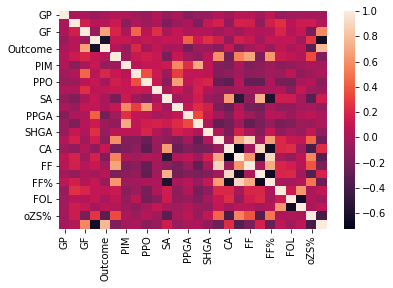

In [76]:
sns.heatmap(spearman)

Now we can drop the columns we do not need:

In [61]:
df1 = df.filter(['GF', 'GA','Outcome', 'PDO','PP%','PK%','oZS%'], axis = 1)
df1.head(5)

,GF,GA,Outcome,PDO,PP%,PK%,oZS%
0,1,5,0,89.3,0,1,63.0
1,3,2,1,102.1,0.5,0.75,57.4
2,3,4,0,101.8,0.25,0,40.0
3,1,3,0,94.4,0,1,31.4
4,2,5,0,88.1,0.25,0.75,55.6


giving us our final dataset for analyzation. Which after insertion of the mean values for 'PK%' and 'PP%' gives us a size of 328 entries for each feature. Which, by our method outlined in (e), meets our dataset size requirements of (10*5/0.49) = 103 (approx.).

In [62]:
df1.count()

GF         328
GA         328
Outcome    328
PDO        328
PP%        328
PK%        328
oZS%       328
dtype: int64

In [63]:
df1.isnull().sum()

GF         0
GA         0
Outcome    0
PDO        0
PP%        0
PK%        0
oZS%       0
dtype: int64

### Training Data (Included for Reference)

In [22]:
X = df1.drop(['Outcome'], axis = 1)
y = df1['Outcome']

In [23]:
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size = 0.3, random_state =1)

In [67]:
X_train.shape

(229, 5)

In [69]:
X_test.shape

(99, 5)

In [25]:
model = LogisticRegression()

In [27]:
model.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

This error leads me to believe that the features had more multicollinearity than I had originally thought. For that reason, I chose to replace 'PP%' and 'PK%' with 'PPG' and 'PPGA', which are only slightly less correlated with 'Outcome', and remove 'GA' all together. In doing this, I drastically reduced the multicollinearity of the independant variables, and as you can see below, increase my model accuracy.

## Checking for Independance

For oZS% and PDO:

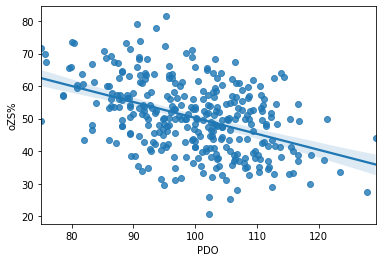

In [96]:
sns.regplot( x = 'PDO', y = 'oZS%', data = df, scatter = True)

For PPG and oZS%:

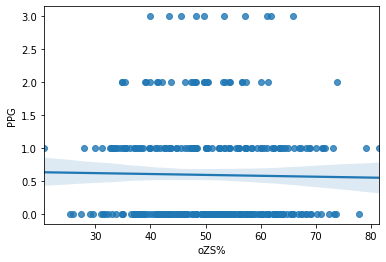

In [103]:
sns.regplot( x = 'oZS%', y = 'PPG', data = df, scatter = True)

For PPGA and oZS%:

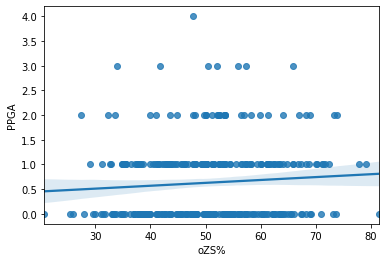

In [104]:
sns.regplot( x = 'oZS%', y = 'PPGA', data = df, scatter = True)

For oZS% and GF:

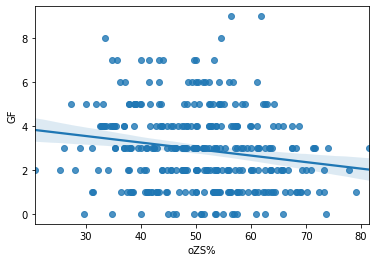

In [105]:
sns.regplot( x = 'oZS%', y = 'GF', data = df, scatter = True)

For PDO vs PPGA:

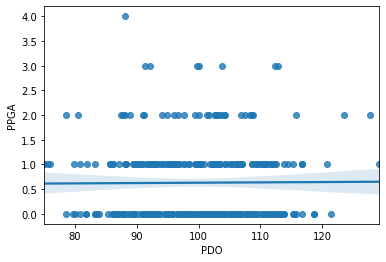

In [106]:
sns.regplot( x = 'PDO', y = 'PPGA', data = df, scatter = True)

For oZS% and GF:

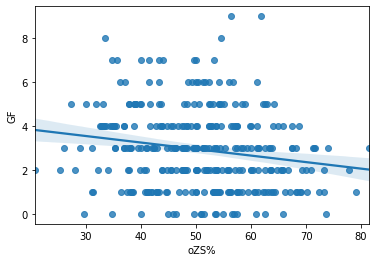

In [101]:
sns.regplot( x = 'oZS%', y = 'GF', data = df, scatter = True)

For PDO and PPG:

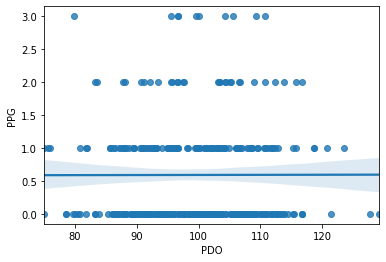

In [100]:
sns.regplot( x = 'PDO', y = 'PPG', data = df, scatter = True)

For PDO vs GF:

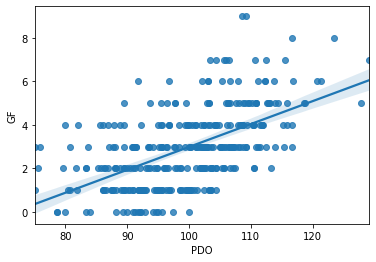

In [109]:
sns.regplot( x = 'PDO', y = 'GF', data = df, scatter = True)

PPG vs PPGA:

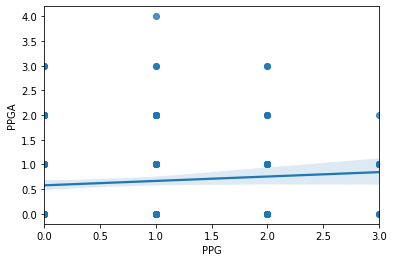

In [110]:
sns.regplot( x = 'PPG', y = 'PPGA', data = df, scatter = True)

PPG vs GF:

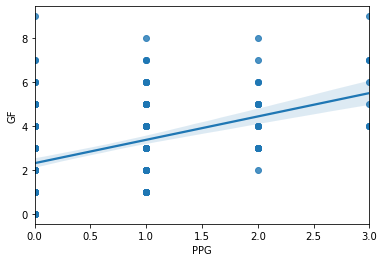

In [112]:
sns.regplot( x = 'PPG', y = 'GF', data = df, scatter = True)

PPGA vs GF:

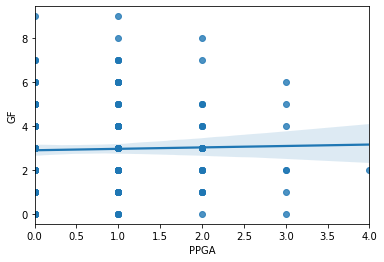

In [113]:
sns.regplot( x = 'PPGA', y = 'GF', data = df, scatter = True)

In [ ]:
Thus, further confirming our earlier assumption of (c).

### Training Data 2 (Actual Dataset)

In [29]:
df2 = df.filter(['Outcome','PDO','oZS%','PPG','PPGA','GF'], axis = 1)
df2.head(5)

,Outcome,PDO,oZS%,PPG,PPGA,GF
0,0,89.3,63.0,0,0,1
1,1,102.1,57.4,1,1,3
2,0,101.8,40.0,1,1,3
3,0,94.4,31.4,0,0,1
4,0,88.1,55.6,1,1,2


In [30]:
df2.isnull().sum()

Outcome    0
PDO        0
oZS%       0
PPG        0
PPGA       0
GF         0
dtype: int64

In [31]:
X = df2.drop(['Outcome'], axis = 1)
y = df2['Outcome']

In [78]:
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size = 0.3, random_state =1)

### Predicting Data

In [79]:
model2 = LogisticRegression()

In [80]:
model2.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [81]:
predictions = model2.predict(X_test)

### Results

In [87]:
cm = confusion_matrix(y_test, predictions)
cm

array([[44,  0],
       [ 2, 53]])

In [83]:
accuracy_score(y_test, predictions)

0.9797979797979798

Therefore, using the features outlined in "Training Data 2", we achieve a model accuracy of approximately 98%, with 44 wins and 53 losses predicted correctly, and only 2 wins predicted incorrectly.

Makin it pretty....

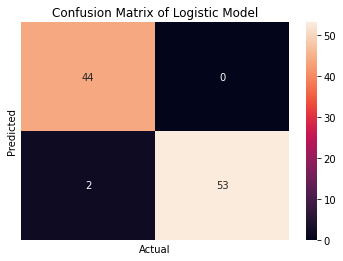

In [94]:
sns.heatmap(cm, annot = True, xticklabels = False, yticklabels = False)
plt.title("Confusion Matrix of Logistic Model")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()